In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
# 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([df_train, df_test], axis = 0)
data.reset_index(inplace = True, drop = True)

PassengerId = df_test['PassengerId']



# **Data Visualization**

<Axes: xlabel='Pclass', ylabel='count'>

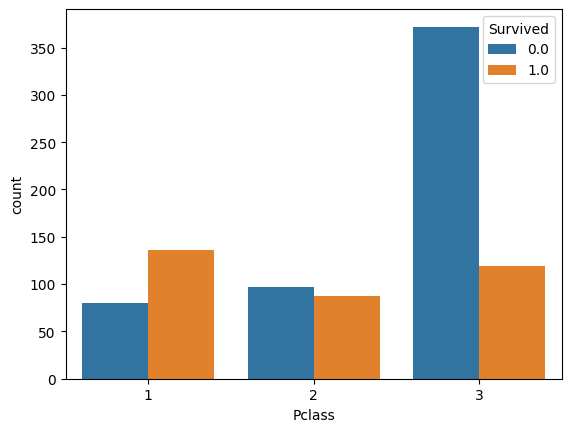

In [2]:
sns.countplot(data = data, x = 'Pclass', hue = 'Survived')

<Axes: xlabel='Sex', ylabel='count'>

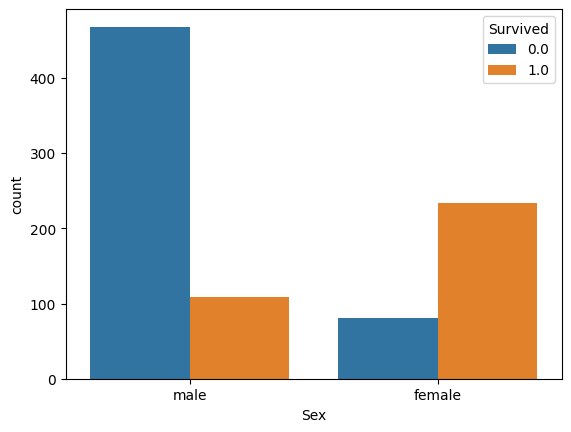

In [3]:
sns.countplot(data = data, x = 'Sex', hue = 'Survived')

<Axes: xlabel='Parch', ylabel='count'>

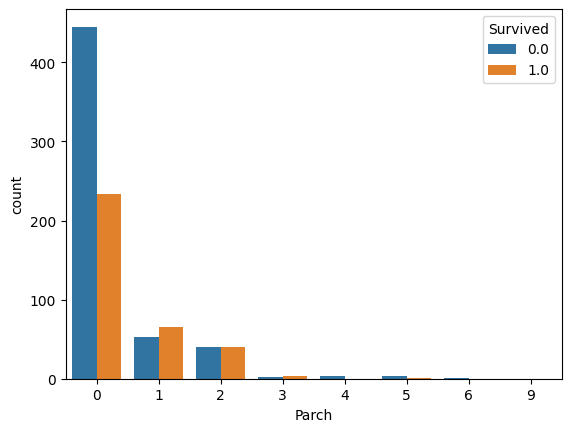

In [4]:
sns.countplot(data = data, x = 'Parch', hue = 'Survived')

<Axes: xlabel='SibSp', ylabel='count'>

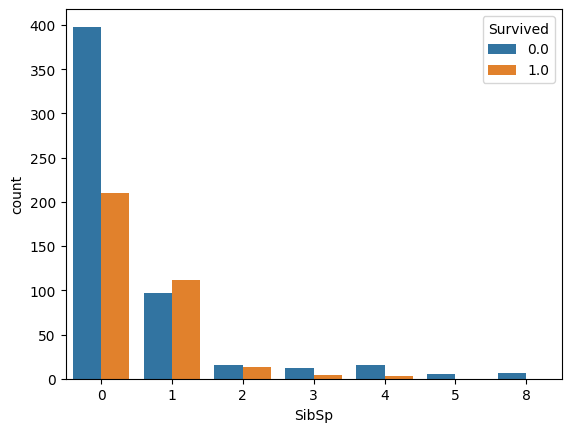

In [5]:
sns.countplot(data = data, x = 'SibSp', hue = 'Survived')

<Axes: xlabel='Embarked', ylabel='count'>

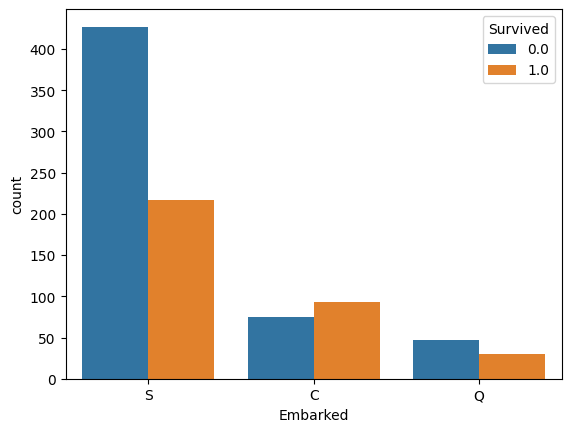

In [6]:
sns.countplot(data = data, x = 'Embarked', hue = 'Survived')

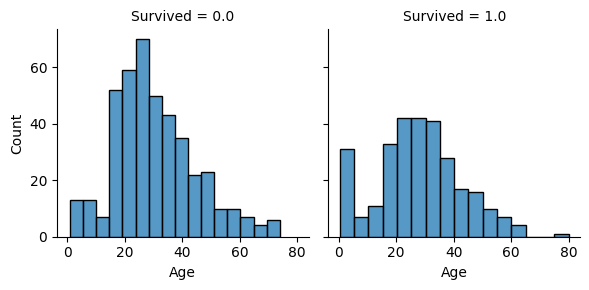

In [7]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'Age', kde = False)

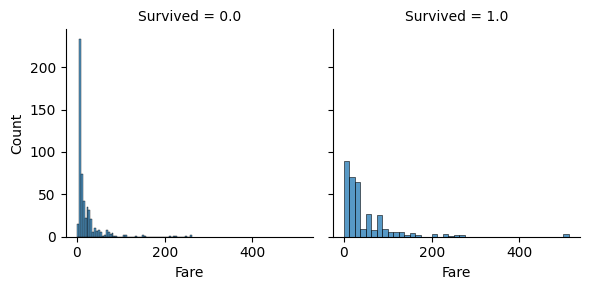

In [8]:
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'Fare', kde = False)

# **Feature Engineering**

In [9]:
data['Fare'].fillna(data.Fare.mean(), inplace = True)

data['family_size'] = data['Parch'] + data['SibSp']

data['prefix'] = data['Name'].str.replace('.', ',').str.split(', ', expand = True)[1]
data['prefix'] = data['prefix'].replace(['Rev', 'Dr', 'Col', 'Mlle', 'Major', 'Ms', 'Lady', 'Sir', 'Mme', 'Don', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                                          ['Mr', 'Mr', 'Mr', 'Miss', 'Mr', 'Miss', 'Miss', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mrs', 'Mr', 'Mrs'])

data['Sex'] = np.where(data['Sex'] == 'male', 1, 0)

data['Ticket'] = data['Ticket'].apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0] if not (x.split(' ')[0][0]).isdigit() else 'X')
data['Ticket'] = data['Ticket'].astype('category').cat.codes

data['Cabin'] = data['Cabin'].apply(lambda x: x[0] if not pd.isnull(x) else 'NoCabin')
data['Cabin'] = data['Cabin'].astype('category').cat.codes

data['Embarked'].fillna('S', inplace = True)
emb = pd.get_dummies(data['Embarked'], drop_first = True)
data = pd.concat([data, emb], axis = 1)
data['Q'] = np.where(data['Q'], 1, 0)
data['S'] = np.where(data['S'], 1, 0)

data['prefix'] = data['prefix'].astype('category').cat.codes


data.drop(['Name', 'SibSp', 'Parch', 'Embarked'], axis = 1, inplace = True)


data.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,family_size,prefix,Q,S
0,1,0.0,3,1,22.0,2,7.2500,7,1,2,0,1
1,2,1.0,1,0,38.0,14,71.2833,2,1,3,0,0
2,3,1.0,3,0,26.0,31,7.9250,7,0,1,0,1
3,4,1.0,1,0,35.0,36,53.1000,2,1,3,0,1
4,5,0.0,3,1,35.0,36,8.0500,7,0,2,0,1


In [10]:
data.describe()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,family_size,prefix,Q,S
count,1309.000000,891.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,0.644003,29.881138,30.428571,33.295479,5.955691,0.883881,1.857143,0.093965,0.699771
std,378.020061,0.486592,0.837836,0.478997,14.413493,10.479504,51.738879,2.057178,1.583639,0.722236,0.291891,0.458533
min,1.000000,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,0.000000,21.000000,31.000000,7.895800,7.000000,0.000000,2.000000,0.000000,0.000000
50%,655.000000,0.000000,3.000000,1.000000,28.000000,36.000000,14.454200,7.000000,0.000000,2.000000,0.000000,1.000000
75%,982.000000,1.000000,3.000000,1.000000,39.000000,36.000000,31.275000,7.000000,1.000000,2.000000,0.000000,1.000000
max,1309.000000,1.000000,3.000000,1.000000,80.000000,36.000000,512.329200,8.000000,10.000000,3.000000,1.000000,1.000000


In [11]:
dataAgeNull = data[data["Age"].isnull()]
dataAgeNotNull = data[data["Age"].notnull()]
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["family_size"]-dataAgeNotNull["family_size"].mean())>(4*dataAgeNotNull["family_size"].std()))                     
                     ]

In [12]:

rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Fare', 'Pclass', 'Sex', 'family_size', 'Cabin','Ticket', 'prefix', 'Q', 'S']
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
data = pd.concat([dataAgeNotNull, dataAgeNull], axis = 0)
data.reset_index(inplace=True, drop=True)

In [13]:
df_train = data[data['Survived'].notnull()].sort_values(by = "PassengerId")
df_test = data[data['Survived'].isnull()].sort_values(by = 'PassengerId')
df_test.drop(['Survived'], axis = 1, inplace = True)

In [14]:
x, y = df_train.drop(['Survived'], axis = 1), df_train['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [15]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 1)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, random_state=1)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)


0.7932960893854749

In [17]:
output = model.predict(df_test)
output = output.astype(int)
output = pd.DataFrame({'PassengerId':PassengerId, 'Survived': output})

output.to_csv('submission.csv', index = False)

In [18]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
